# 0. 필요한 모듈 import

In [51]:
# 필요한 modules import

import cv2
import numpy as np
import os
import tarfile
import urllib # 웹에서 데이터를 다운로드할때 사용

from matplotlib import pyplot as plt
import tensorflow as tf

In [52]:
# 구글에서 제공하는 모델 구조를 그대로 가지고 와 DeepLabModel 클래스를 만들겠습니다.

class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
            tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map
    
    print('done')

done


preprocess(): 전처리 함수

##### 이미지를 적절한 크기로 resize
##### Chanege: OpenCV default BGR → RGB
##### 이미지를 input tenser로 변형하여 return
##### run(): 세그멘테이션 함수

전처리 된 이미지 run() 함수에서 입력값으로 사용

### 구글에서 제공하는 사전에 학습 된 가중치 (pretrained weight) 불러오기
구글이 제공하는 deeplabv3_mnv2_pascal_train_aug_2018_01_29 weight을 다운로드 하고, DeepLabModel 을 초기화합니다.

이 모델은 PASCAL VOC 2012라는 대형 데이터셋으로 학습된 v3 버전입니다.

In [53]:
# deeplabv3_mnv2_pascal_train_aug_2018_01_29 weight 다운로드
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

# DeepLabModel 초기화
MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /aiffel/aiffel/human_segmentation/models
model loaded successfully!


# 1. 배경이 단순한 인물 이미지 검출

In [54]:
# 배경이 단순한 사람 이미지 로드

import os
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/yujin.png'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
img_orig = cv2.imread(img_path) 
print ("이미지 크기 :", img_orig.shape)

이미지 크기 : (850, 850, 3)


In [55]:
# 첫 단계에서 준비한 이미지를 네트워크에 입력
# cv2는 이미지를 HWC(Height, Width, Channel) 순서로 표시한다는 것을 명심할 것!!
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max()) #seg_map.max() : 세그멘테이션 맵에서 가장 큰 값(물체로 인식된 라벨 중 가장 큰 값)

(850, 850, 3) (513, 513, 3) 15


위에 코드에서 seg_map.max() 값이 15가 나왔는데 해당하는 의미는 아래의 LABEL_NAMES를 통해서 15번째인 person인 것을 알 수 있다.

In [56]:
# 제공하는 라벨 종류

LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

# 2. Segmentation으로 사람 분리

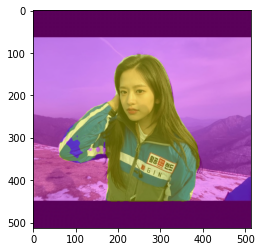

In [57]:
# 사람만 검출해내고 싶기 때문에 사람(person) 라벨, 즉 15를 가진 영역만 검출하기
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 일반 이미지는 0부터 255 까지의 값을 사용해 픽셀을 표현하므로, 세그멘테이션 맵에 표현된 값을 원본 이미지에 그림 형태로 출력하기 위해 255 normalization
img_mask = img_mask.astype(np.uint8)
# cv2.applyColorMap - 제공되는 칼라맵을 적용하여 색감을 완전히 변화시킬 수 있음
# 색을 적용하고 이미지를 화면에 출력
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_SPRING) # 기본 COLORMAP_JET은 잘 안보여서 COLORMAP_SPRING으로 바꿈
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

사람을 뜻하는 15를 제외한 모든 예측은 0으로 설정. 예측된 Segmentation은 이미지는 최대값이 15가 될 것. 일반 이미지는 0~255까지의 값을 사용하여 픽셀을 표현하므로, 255로 정규화 함, applycolorMap() 함수로 색을 지정하고 이미지를 출력시킴

# 3. Segmentation결과를 원래 크기로 복원

DeepLab 모델을 사용하기 위해 이미지 크기를 작게 resize 하여 입력 시 , 출력도 reseize된 입력 크기와 같게 나온다.
그러므로 , 위에서 나온 Segmentation 결과(mask)를 원래 크기로 복원을 진행함

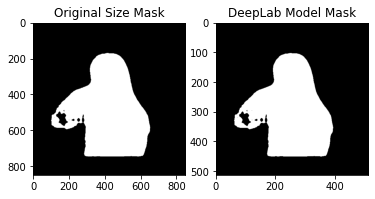

In [58]:
# cv2.INTER_NEAREST를 이용해서 깔끔하게 처리할 수 있지만 더 정확히 확대하기 위해 cv2.INTER_LINEAR 를 사용
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR) # 크기를 키울 때 보간(interpolation) 을 고려
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)
# img_mask_up 은 경계가 블러된 픽셀값 0~255의 이미지를 얻는데 확실한 경계를 다시 정하기 위해 중간값인 128을 기준으로 임계값(threshold)을 설정
# 128 이하의 값은 0으로 128 이상의 값은 255로 만드는 방법임

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

원본과 DeepLab Model 간의 x,y 좌표가 다른 것을 통해 resize가 되고 되지 않고를 알 수 있다.

# 4. 배경 흐리게 하기

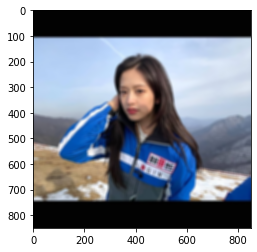

In [59]:
# blur()함수를 이용해서 배경을 흐리게 만들기
img_orig_blur = cv2.blur(img_orig, (13,13)) #(13,13)은 blurring  kernel size를 뜻합니다. 
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

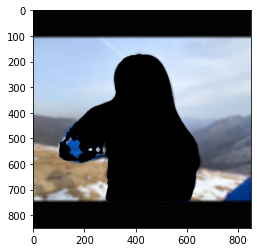

In [60]:
# 흐려진 이미지에서 세그멘테이션 마스크를 이용해서 배경만 추출
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

흐린 배경과 원본 이미지 합성

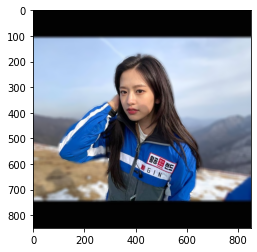

In [61]:
# 세그멘테이션 마스크가 255인 부분만 원본 영상을 가지고 오고 반대인 영역은 블러된 이미지 값을 사용
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

# 배경이 복잡한 사람 이미지 검출

In [62]:
# (배경이 복잡하고 몸이 돌아간) 사람 이미지 로드

import os
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/JIWON1.jpg'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
img_orig = cv2.imread(img_path)
print ("이미지 크기 :", img_orig.shape)

이미지 크기 : (850, 850, 3)


# 1. Segmentation으로 사람 분리하기

(850, 850, 3) (513, 513, 3) 15


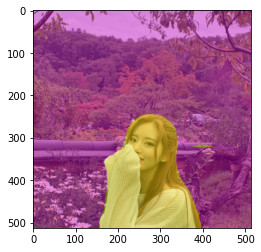

In [63]:
# 이미지 resize
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())
# cv2는 채널을 HWC 순서로 표시

# Segmentation으로 사람 분리하기
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 일반 이미지는 0부터 255 까지의 값을 사용해 픽셀을 표현하므로, 세그멘테이션 맵에 표현된 값을 원본 이미지에 그림 형태로 출력하기 위해 255 normalization
img_mask = img_mask.astype(np.uint8)
# cv2.applyColorMap - 제공되는 칼라맵을 적용하여 색감을 완전히 변화시킬 수 있음
# 색을 적용하고 이미지를 화면에 출력
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_SPRING) # 기본 COLORMAP_JET은 잘 안보여서 COLORMAP_SPRING으로 바꿈
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

# 2. Segmentation 결과를 원래 크기로 복원

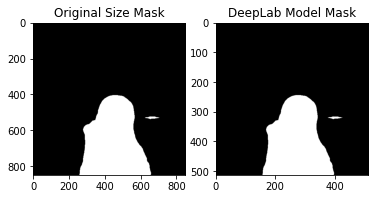

In [64]:
# 이미지 사이즈 비교
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

# 3. 배경 흐리게 하기

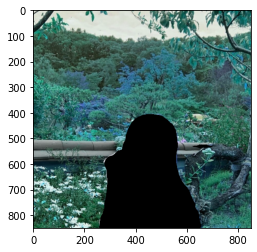

In [65]:
# 배경 흐리게 하기
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg = cv2.bitwise_and(img_orig, img_bg_mask)
plt.imshow(img_bg)
plt.show()

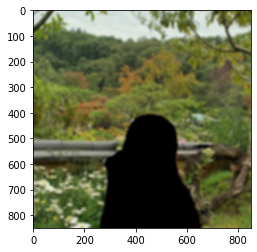

In [66]:
img_bg_blur = cv2.blur(img_bg, (13,13))
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

# 4. 흐린 배경과 원본 영상 합성

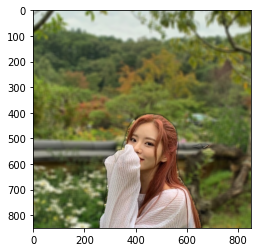

In [67]:
# 흐린 배경과 원본 이미지 합성 후 저장
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
save_path = os.getenv('HOME')+'/aiffel/human_segmentation/images_blurred/jiwon2.jpg'
cv2.imwrite(save_path, img_concat)

plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

# 고양이 이미지 검출

In [68]:
# 고양이 이미지 로드

import os
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/cat.png'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
img_orig = cv2.imread(img_path)
print ("이미지 크기 :", img_orig.shape)

이미지 크기 : (591, 625, 3)


# 1. Segmentation으로 고양이 분리하기

(591, 625, 3) (485, 513, 3) 8


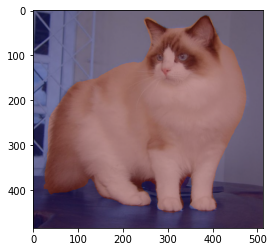

In [69]:
# 이미지 resize
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())
# cv2는 채널을 HWC 순서로 표시

# Segmentation으로 고양이 분리하기
img_show = img_resized.copy()
seg_map = np.where(seg_map == 8, 8, 0)
# 예측 중 고양이만 추출 cat의 label은 8

img_mask = seg_map * (255/seg_map.max())
# 255 normalization(이미지 정규화)

img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

# 2. Segmentation 결과를 원래 크기로 복원

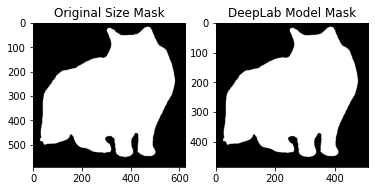

In [78]:
# 이미지 사이즈 비교
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

# 3. 배경 흐리게 하기

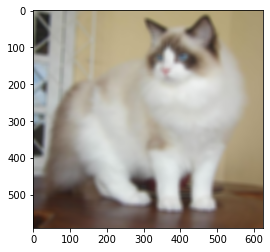

In [71]:
# blur()함수를 이용해서 배경을 흐리게 만들기
img_orig_blur = cv2.blur(img_orig, (13,13)) #(13,13)은 blurring  kernel size를 뜻함 
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

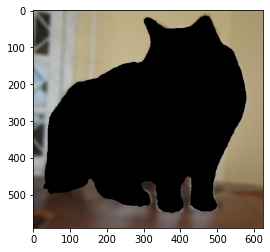

In [72]:
# 흐려진 이미지에서 세그멘테이션 마스크를 이용해서 배경만 추출
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

# 4. 흐린 배경과 원본 영상 합성

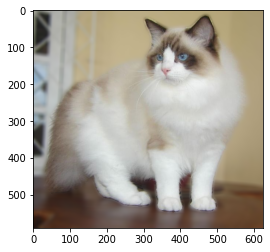

In [73]:
# 세그멘테이션 마스크가 255인 부분만 원본 영상을 가지고 오고 반대인 영역은 블러된 이미지 값을 사용
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

# 배경 합성하기

## 1. 합성사진 준비

이미지 크기 : (1420, 1920, 3)


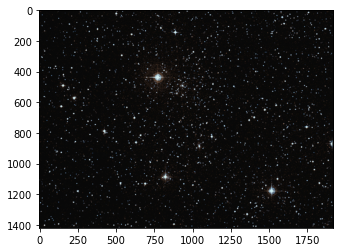

In [74]:
# 배경 이미지 불러오기
bg_img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/galaxy.jpg'  # 본인이 사용할 사진의 경로
bg_img_orig = cv2.imread(bg_img_path)
print("이미지 크기 :" , bg_img_orig.shape)

bg_img_rgb = cv2.cvtColor(bg_img_orig, cv2.COLOR_BGR2RGB)
plt.imshow(bg_img_rgb)
plt.show()

(591, 625, 3)


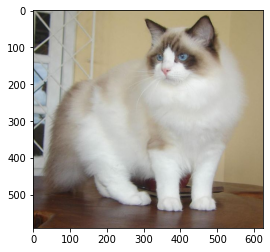

In [83]:
# 이미지 불러오기
cat_img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/cat.png'  # 본인이 사용할 사진의 경로
cat_img_orig = cv2.imread(cat_img_path)
print(cat_img_orig.shape)

cat_img_rgb = cv2.cvtColor(cat_img_orig, cv2.COLOR_BGR2RGB)
plt.imshow(cat_img_rgb)
plt.show()

## 2. 배경 이미지 사이즈 변경

In [84]:
# 배경 이미지와 고양이 이미지 크기 맞추기
target_size = (cat_img_orig.shape[1], cat_img_orig.shape[0])
bg_resized = cv2.resize(bg_img_orig, target_size)  # 배경 이미지를 target size 크기로 resize 합니다.

## 3. 배경 이미지에 고양이와 합성

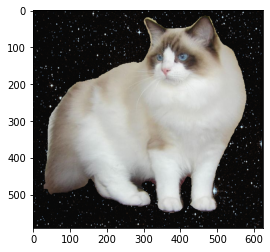

In [85]:
# 배경과 원본 이미지 합성하기
# 앞에서 segementation 작업을 통해 이미 만들어둔 고양이 사진에 수영장 이미지를 합성합니다.

img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_concat3 = np.where(img_mask_color==255, cat_img_orig, bg_resized)

plt.imshow(cv2.cvtColor(img_concat3, cv2.COLOR_BGR2RGB))
plt.show()

# 회고

#### 문제점
빨간색으로 표시한 부분은 제대로 segmentation이 되지 않는다는 문제점이 발생하였다. 배경이 단순한 인물사진의 경우 아웃포커싱을 주고 다시 합성 하여도 어색하지 않았지만, 배경이 복잡한 인물의 경우 아웃포커싱을 주고 다시 합성했을 때, 사진에서 뭔가 모를 어색함이 느껴지는 것 같기도 하다. 누끼따는 작업을 했을 시(하단 3장)

![result](images/RESULT.png)

#### segmentation의 한계
Semantic segmentation의 부정확성이 여러 가지 문제를 발생시키는 주요 원인입니다. 피사계심도를 이용한 보케(아웃포커싱) 효과는 말 그대로 심도를 표현하기 때문에 초점이 잡힌 거리를 광학적으로 아주 섬세하게 구별(segmentation) 하지만 이를 따라 한 semantic segmentation 모듈은 정확도가 1.00 이 되지 않는 한 완벽히 구현하기는 힘듭니다.

#### 피사계 심도란?
내가 찍는 피사체에 포커스가 집중되어 선명하게 보이는 피사체 앞뒤 영역의 두께 혹은 깊이를 의미하며, 피사체 뒷 배경이 얼마나 흐릿한지의 척도가 된다. 피사계 심도가 깊으면 배경까지 선명해지고, 피사계 심도가 낮으면 피사체에 포커스가 집중된다.

#### 보케란?
이미지의 아웃 포커스 부분에 미적인 블러 효과를 만들어내는 사진 표현 방법이다. 보케는 "렌즈가 빛의 아웃 포커스 지점을 표현하는 방법"

#### 스마트폰으로는 가능?
가능하다. 하지만 카메라 스펙의 차이때문에 DSLR만큼의 효과는 볼 수 없을 것

#### 광학적으로 흐리지 못한다면, 심도를 계산하여 흐리게 할 수 있을까?
#### 이미 촬영된 사진에 심도를 넣을려면?
- 관심 있는 객체의 경계선 안팎에서 사진이 흐려지는 정도를 계산하여 더 많이 흐려진 부분은 객체와 멀리 떨어진 부분으로 판단해야 한다.                                                                                       
- 미리 이미지를 학습시킨 네트워크에 넣고 획득한 반대 이미지를 이용하여 심도를 계산(?)

#### 사진을 촬영 할 때부터 심도를 계산에 두고 촬영할려면?
- 하나의 카메라로 초점이 다른 여러사진을 촬영
- 스펙이 같은 2개의 카메라로 양안 이미지를 생성

### 해결방안?
#### 3D Depth Camera
https://blog.naver.com/panoptics/221336152952

#### 깊이 영상 활용
https://blog.naver.com/PostView.naver?isHttpsRedirect=true&blogId=cooms_visual&logNo=220429794130

#### IR(적외선)
https://www.axis.com/files/whitepaper/wp_ir_in_surveillance_72295_ko_1808_lo.pdf
구글 pixel4에 IR 카메라가 있으며 3D Depth Sensing이 가능함



#### 후기
예전부터 카메라에 대해서 관심은 있었지만, 많이 공부 하지는 못했다. 이번 과제를 통하여 카메라에 대해서 많이 알게 되었으며, 해당 과정을 코딩을 하여 인공지능까지 써보는 것까지 해보면서 여러가지를 습득하는 시간이 되었다.
벌써 7번째 과제를 치루고 있지만 매번 새로운걸 공부하는거라 매번 늘 어렵다고 느낀다. 언제쯤 익숙해질까